Using CPU. Note: This module is much faster with a GPU.


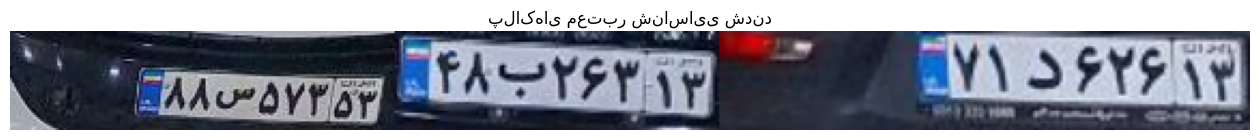

متون پلاک‌های شناسایی‌شده:
پلاک 1: ۵۷۳۵۳س۶۸
پلاک 2: ۱۳ ۲۶۳ب۰۴۸
پلاک 3: ۶۳ ۶۲۴ ۵ ۶۷۱


In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import easyocr
import re

# --- بارگذاری تصویر ---
image_path = 'C:/Users/koosha/Desktop/car plate recignition images/15.jpg'
car_img = cv.imread(image_path)
car_img_gray = cv.cvtColor(car_img, cv.COLOR_BGR2GRAY)

# --- افزایش کنتراست و کاهش نویز ---
clahe = cv.createCLAHE(clipLimit=6.0, tileGridSize=(8, 8))
enhanced = clahe.apply(car_img_gray)
blurred = cv.bilateralFilter(enhanced, 11, 75, 75)

# --- آستانه‌گذاری تطبیقی ---
thresh = cv.adaptiveThreshold(blurred, 255, cv.ADAPTIVE_THRESH_MEAN_C,
                               cv.THRESH_BINARY_INV, 25, 10)

# --- یافتن کانتورها ---
contours, _ = cv.findContours(thresh, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

# --- فیلتر کانتورها بر اساس ابعاد پلاک ---
img_height, img_width = car_img.shape[:2]
plates = []
for cnt in contours:
    x, y, w, h = cv.boundingRect(cnt)
    aspect_ratio = w / float(h)
    area = cv.contourArea(cnt)

    if 2.0 < aspect_ratio < 5.5 and 1000 < area < 6000 and w > 90 and h > 25:
        if img_height * 0.3 < y < img_height * 0.85:
            plates.append((x, y, w, h))

# --- حذف نواحی تکراری نزدیک به هم ---
final_plates = []
for (x, y, w, h) in plates:
    if all(abs(x - fx) > 40 or abs(y - fy) > 40 for (fx, fy, fw, fh) in final_plates):
        final_plates.append((x, y, w, h))

# --- راه‌اندازی OCR فقط برای زبان فارسی ---
reader = easyocr.Reader(['fa'], gpu=False)
plate_texts = []
plate_rois = []

# --- تابع اصلاح ارقام عربی به فارسی و اصلاحات متنی ---
def clean_plate_text(text):
    # تبدیل ارقام عربی به فارسی
    arabic_to_persian_digits = str.maketrans("٠١٢٣٤٥٦٧٨٩", "۰۱۲۳۴۵۶۷۸۹")
    text = text.translate(arabic_to_persian_digits)

    # اصلاح اشتباهات رایج OCR
    replacements = {
        '!': '۱',
        'l': '۱',
        'I': '۱',
        'o': '۰',
        'O': '۰',
        'T': '۷',
        'S': '۵',
        ',': '',
        '.': '',
        '-': ' ',
        '|': '۱',
        '”': '',
        '“': '',
        '‘': '',
        '\'': ''
    }

    for k, v in replacements.items():
        text = text.replace(k, v)

    # حذف کاراکترهای غیرمجاز
    text = re.sub(r'[^۰-۹آ-ی ]+', '', text)
    return text.strip()

# --- پردازش نواحی پلاک و خواندن OCR ---
for (x, y, w, h) in final_plates:
    roi = car_img[y:y+h, x:x+w]

    gray_roi = cv.cvtColor(roi, cv.COLOR_BGR2GRAY)
    gray_roi = cv.resize(gray_roi, None, fx=6, fy=6, interpolation=cv.INTER_CUBIC)
    _, roi_thresh = cv.threshold(gray_roi, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)

    result = reader.readtext(roi_thresh, detail=1, paragraph=False)
    text = " ".join([res[1] for res in result])

    cleaned_text = clean_plate_text(text)

    if len(cleaned_text) >= 6 and any(c.isdigit() for c in cleaned_text):
        plate_texts.append(cleaned_text)
        plate_rois.append(roi)

# --- نمایش پلاک‌های استخراج‌شده ---
if plate_rois:
    max_height = max([roi.shape[0] for roi in plate_rois])
    resized_rois = [cv.resize(roi, (int(roi.shape[1] * max_height / roi.shape[0]), max_height)) for roi in plate_rois]
    combined = cv.hconcat(resized_rois)
    plt.figure(figsize=(16, 5))
    plt.imshow(cv.cvtColor(combined, cv.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title("پلاک‌های معتبر شناسایی شدند")
    plt.show()
else:
    print("پلاک معتبری یافت نشد.")

# --- نمایش خروجی متنی ---
print("متون پلاک‌های شناسایی‌شده:")
for i, text in enumerate(plate_texts, 1):
    print(f"پلاک {i}: {text}")
